In [1]:
import os

import pandas as pd
import pickle as pkl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import patsy

%matplotlib inline
cmap = sns.diverging_palette(10, 240, as_cmap=True)

In [2]:
run_name = '1'
path = '../data/' + run_name + '/scores/'
da_classifier = "DA (2)"
comparison_classifier = "SVM"


scores = []
i = 0

for file in os.listdir(path):
    if file.endswith('.p'):
        score_dict = pkl.load(open(path + '/' + file, 'rb'))        
        missing = 0
        
        if file.startswith('m'):
            split_file = file.split('_')
            missing = float(split_file[0][1:])
            split_file = split_file[1:]  
        else:
            split_file = file.split('_')

        for s in score_dict.keys():
            score = {}
            score['missing'] = missing
            score['model'] = int(split_file[0])
            score['effects'] = int(split_file[1])
            score['per_effect'] = int(split_file[2])
            score['mag'] = float(split_file[3])
            score['observed'] = int(split_file[4])
            score['trial'] = int(split_file[5].split('.')[0])+1
            score['patients'] = s
            
            for m in score_dict[s]:
                score[m] = np.mean(score_dict[s][m])
        
            scores.append(score)

df = pd.DataFrame(scores)
print(df.columns)
df = df.rename(columns={'fullrfc': 'Random Forest', 'rfc': 'Limited Random Forest', 
                        'nearest_neighbors': 'Nearest Neighbors', 'svm': 'SVM', 
                        'tree': 'Decision Tree', 'da_10000_2_fullrfc': 'DA (2)', #,
                        'da_10000_4_fullrfc': 'DA (4)', 'da_10000_8_fullrfc': 'DA (8)',
                        'da_10000_16_fullrfc': 'DA (16)'}) #, 'da_1000_8_fullrfc': 'DA (1000)',})
# df = df.rename(columns={'da_2000_2_fullrfc': 'DA (2)', 'da_2000_4_fullrfc': 'DA (4)', 
#                         'da_2000_8_fullrfc': 'DA (8)', 'da_2000_16_fullrfc': 'DA (16)'}) #, 'da_1000_8_fullrfc': 'DA (1000)',})
df['diff'] = df[da_classifier] - df[comparison_classifier]
df = df[np.isfinite(df['missing'])]
df_select = df
# df = df.loc[(df['effects'] == 1) | (df['effects'] == 3)]

Index(['da_10000_2_fullrfc', 'da_10000_2_nearest_neighbors', 'da_10000_2_rfc',
       'da_10000_2_svm', 'da_10000_2_tree', 'effects', 'fullrfc', 'mag',
       'missing', 'model', 'nearest_neighbors', 'observed', 'patients',
       'per_effect', 'rfc', 'svm', 'tree', 'trial'],
      dtype='object')


### Overall Comparison (DA vs. SVM)

In [3]:
expected_e = {1:1, 2: 1, 4:0.6875, 8:0.64, 16:0.6}

print(df['patients'].unique())
results_df = pd.DataFrame()

if run_name in ['ex2']:
    four_col = df[['effects', 'mag', 'patients', 'Random Forest', 'Nearest Neighbors', comparison_classifier,
                   'DA (16)', 'DA (8)', 'DA (4)',
                   'DA (2)']]
    four_col = four_col.rename(columns={'Random Forest':'RF', 'Nearest Neighbors': 'NN', 'svm': 'SVM'})
    
    print(four_col.shape)
    for e in four_col['effects'].unique():
        df_select = four_col.loc[(four_col['effects'] == e)  & (four_col['mag'] == 5)] # & (four_col['patients'] == 200)]
        df_select.drop(['effects', 'mag', 'patients'], axis=1, inplace=True)
        print((df_select / expected_e[e]).shape)
        
        results_df = pd.concat([results_df, (df_select / expected_e[e])])
        print(results_df.shape)
        
    print(results_df.mean())
    plt.figure(figsize=(10,10))
    sns.set_style("whitegrid")
    sns.set_context("poster")
    g = sns.boxplot(data=results_df, palette="husl", notch=True)
    g.set_title('Percent of Expected Max Classification')

if run_name in ['ex3', 'model4_high']:
    four_col = df[['effects', 'mag', 'patients', 'Random Forest', 'Nearest Neighbors', comparison_classifier,
                   'DA (16)', 'DA (8)', 'DA (4)',
                   'DA (2)']]
    four_col = four_col.rename(columns={'Random Forest':'RF', 'Nearest Neighbors': 'NN', 'svm': 'SVM'})
    
    print(four_col.shape)
    for e in four_col['effects'].unique():
        if e <8:
            df_select = four_col.loc[(four_col['effects'] == e)  & (four_col['mag'] == 10)] # & (four_col['patients'] == 1000)]
            df_select.drop(['effects', 'mag', 'patients'], axis=1, inplace=True)
            results_df = pd.concat([results_df, (df_select)])
#         print((df_select / expected_e[e]).shape)        
#         results_df = pd.concat([results_df, (df_select / expected_e[e])])
#         print(results_df.shape)
        
    print(results_df.mean())
    plt.figure(figsize=(10,10))
    sns.set_style("whitegrid")
    sns.set_context("poster")
    g = sns.boxplot(data=results_df, palette="husl", notch=True)
    g.set_title('ROC AUC - Model 4')

[ 200  100  500 1000 2000]


In [4]:
for p in df['patients'].unique():
    print(p)

200
100
500
1000
2000


In [5]:
p_df = pd.DataFrame()

for p in df['patients'].unique():
    p_df[p] = df.loc[(df['patients'] == p)].mean()

p_df = p_df.T
p_df = p_df.drop(['model', 'observed', 'patients', 'per_effect', 'effects', 'mag', 'missing', 'trial',
                 'diff'], axis=1)
print(p_df)
# pt = p_df.pivot_table(values=da_classifier, index="patients", columns="observed", aggfunc='mean')
# sns.heatmap(pt, annot=True)

# print(p_df)
# plt.figure(figsize=(20,10))
# ax = plt.axes()
# pt = df.pivot_table(values=da_classifier, index="patients", columns="observed", aggfunc='mean')
# sns.heatmap(pt, annot=True, cmap=cmap, fmt="f", vmin=0, vmax=1, linewidths=.5, ax = ax)
# ax.set_title(da_classifier + ' mean ROC score')

        DA (2)  da_10000_2_nearest_neighbors  da_10000_2_rfc  da_10000_2_svm  \
200   0.827141                      0.795815        0.826119        0.792429   
100   0.814994                      0.792232        0.820862        0.781069   
500   0.827607                      0.802691        0.827354        0.824112   
1000  0.826864                      0.801597        0.825957        0.834758   
2000  0.827231                      0.800138        0.826836        0.841083   

      da_10000_2_tree  Random Forest  Nearest Neighbors  \
200          0.777215       0.737994           0.711003   
100          0.766418       0.705755           0.705873   
500          0.779361       0.773250           0.734244   
1000         0.779580       0.792338           0.740954   
2000         0.777430       0.803390           0.748945   

      Limited Random Forest       SVM  Decision Tree  
200                0.678148  0.625760       0.650108  
100                0.642513  0.538740       0.634302  

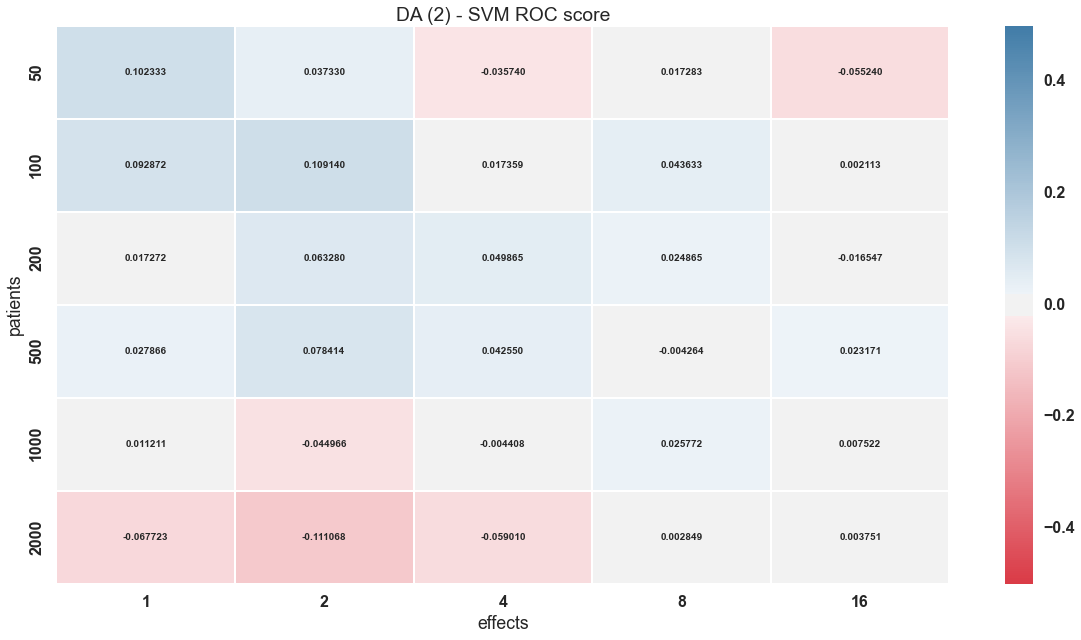

In [28]:
plt.figure(figsize=(20,10))
ax = plt.axes()
pt = df_select.pivot_table(values='diff', index="patients", columns="effects", aggfunc='mean')
sns.heatmap(pt, annot=True, fmt="f", vmin=-0.5, vmax=0.5, cmap=cmap, linewidths=.5)
ax.set_title(da_classifier + ' - ' + comparison_classifier + ' ROC score')    

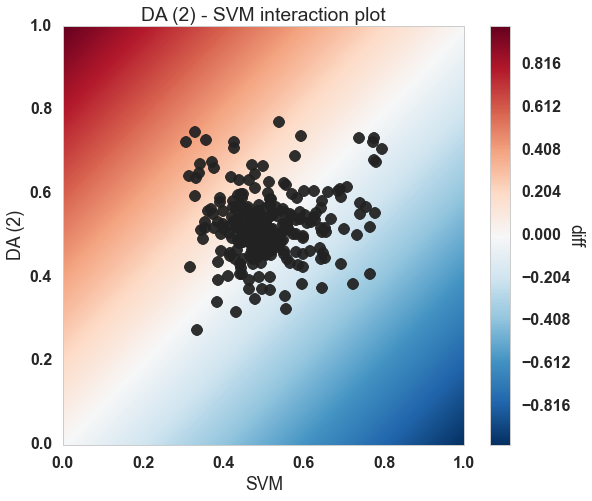

In [29]:
plt.figure(figsize=(9,7.5))
ax = plt.axes()
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
sns.interactplot(comparison_classifier, da_classifier, "diff", df_select, 
                 filled=1, levels=500)
ax.set_title(da_classifier + ' - ' + comparison_classifier + ' interaction plot')

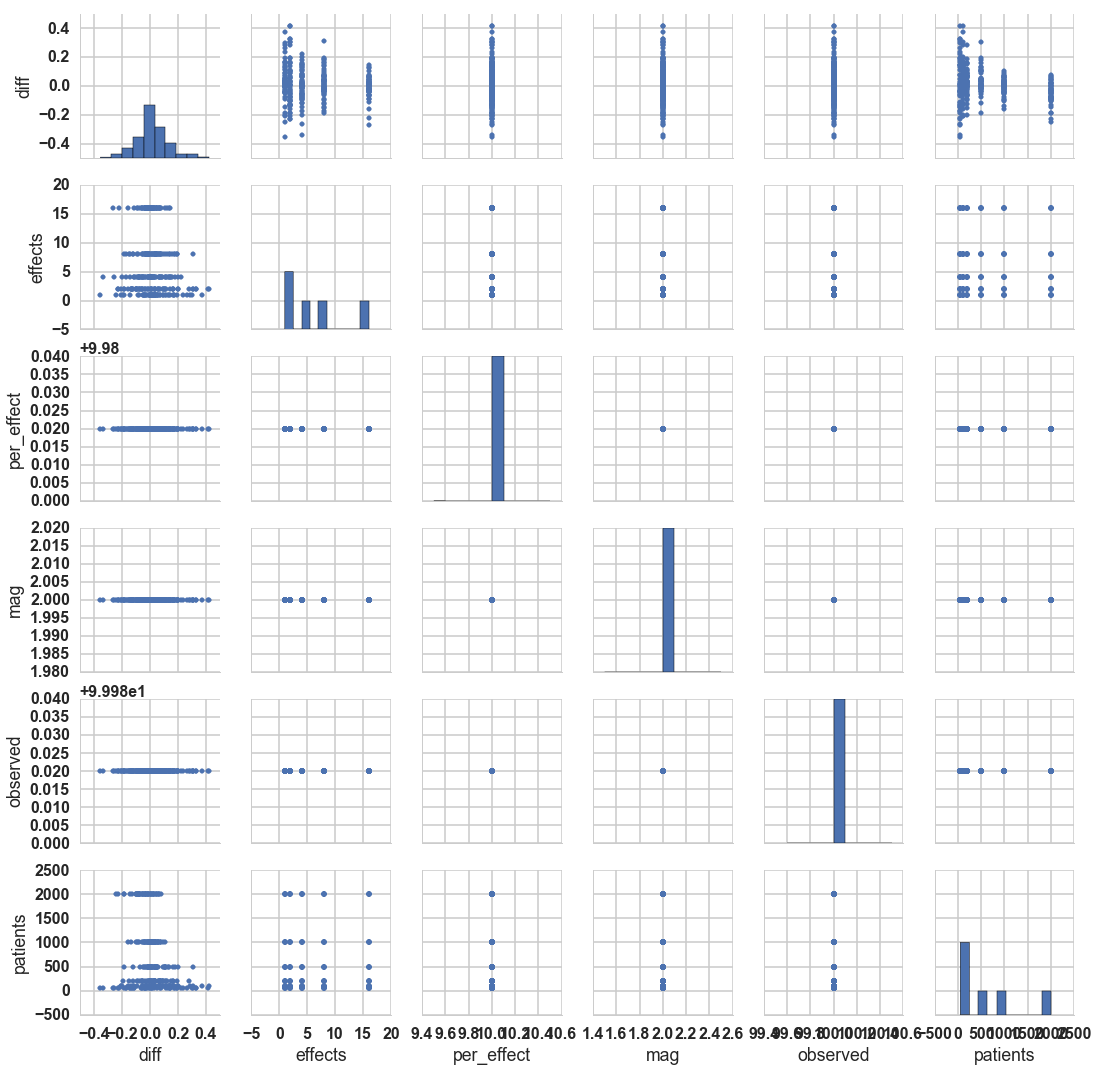

In [30]:
plt.figure(figsize=(10,10))
selected_cols = df_select[['diff', 'effects', 'per_effect', 'mag', 'observed', 'patients']]
sns.pairplot(selected_cols)

/usr/local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


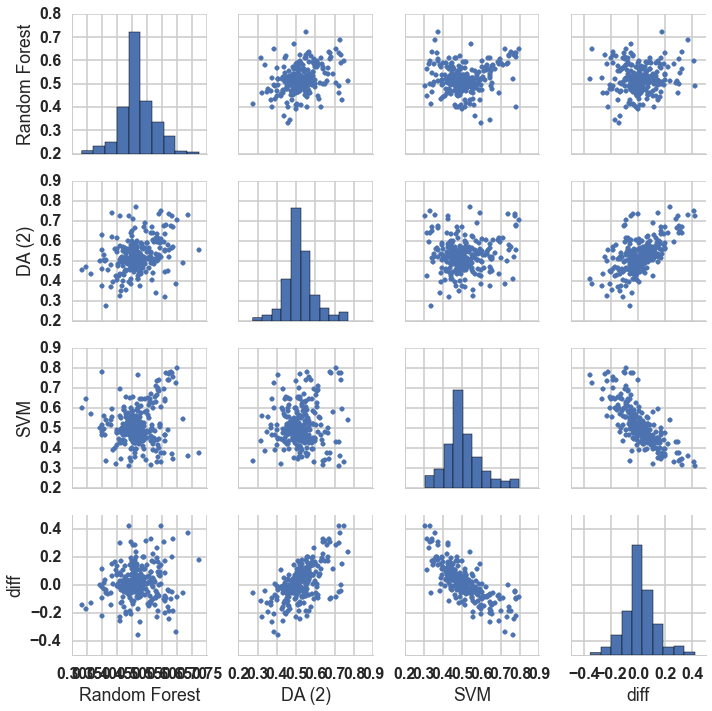

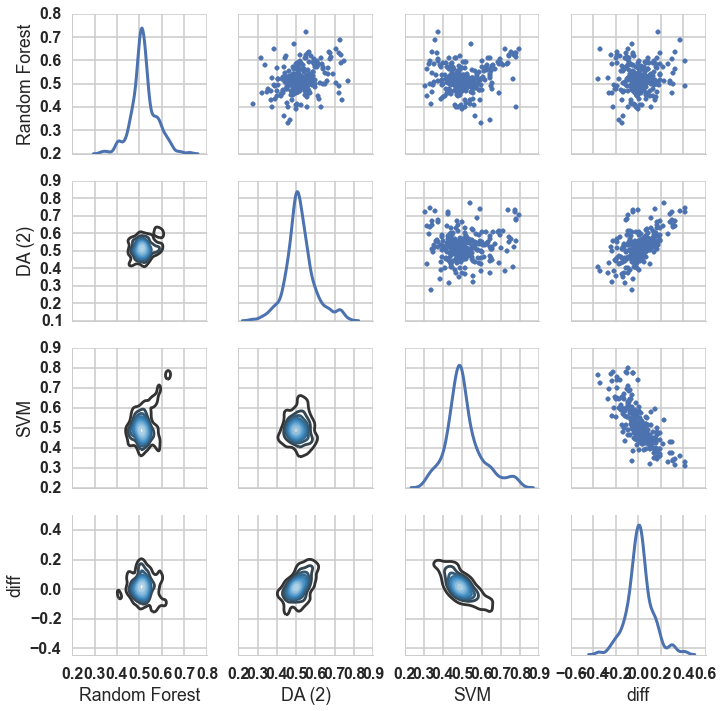

In [31]:
plt.figure(figsize=(10,10))
selected_cols = df[['Random Forest', da_classifier, comparison_classifier, 'diff']]
sns.pairplot(selected_cols)

g = sns.PairGrid(selected_cols, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

### Patient Count

2000
200
50
500
1000
100


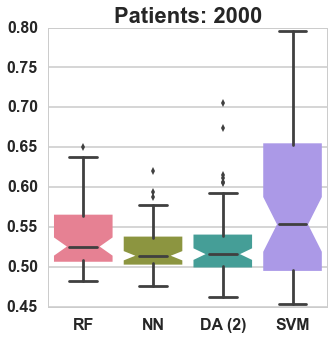

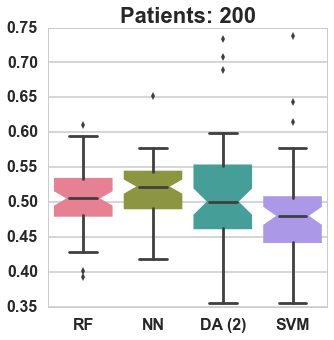

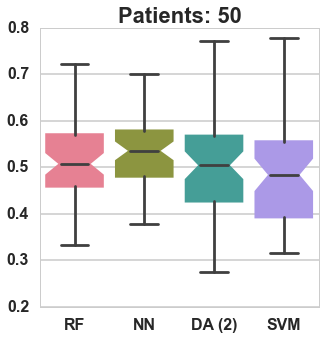

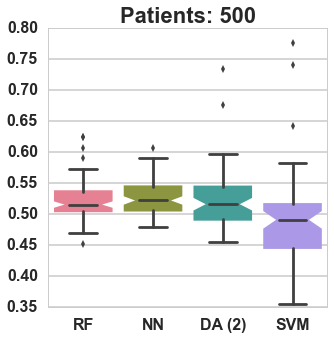

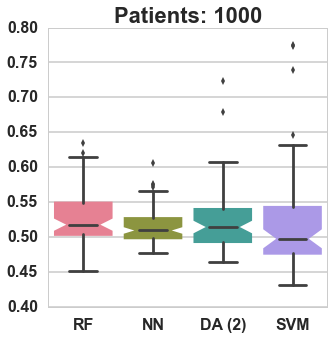

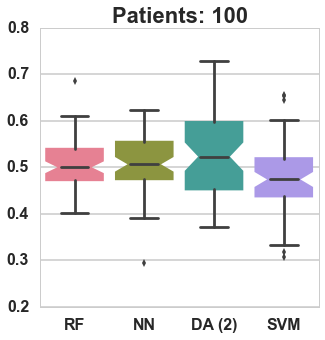

In [32]:
font = {'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
for p in df['patients'].unique():
    print(p)
    df_select = df.loc[(df['patients'] == p)] #& (df['effects'] == 8) & (df['patients'] == 500)
    #                  & (df['mag'] == 1)] & (df['effects'] == 2) & (df['observed'] == 100)]

    four_col = df_select[['Random Forest', 'Nearest Neighbors', da_classifier, comparison_classifier]] #, 'da_2000_2_tree', 'svm']]
    four_col = four_col.rename(columns={'Random Forest':'RF', 'DA (10000)':'DA',
                       'Nearest Neighbors': 'NN', 'svm': 'SVM'})
    
    plt.figure(figsize=(5,5))
    sns.set_style("whitegrid")
    sns.set_context("poster")
    g = sns.boxplot(data=four_col, notch=True, palette="husl")
    g.set_title('Patients: ' + str(p), fontdict=font)
#     g.set_xaxis

16
1
2
4
8


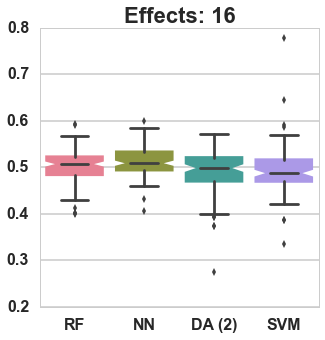

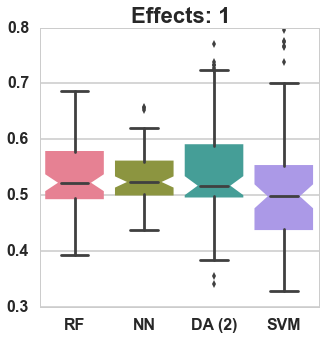

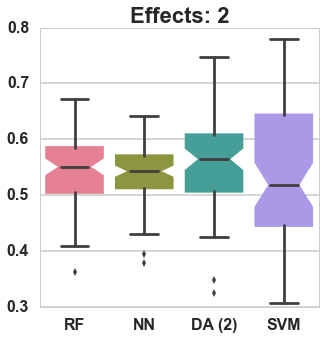

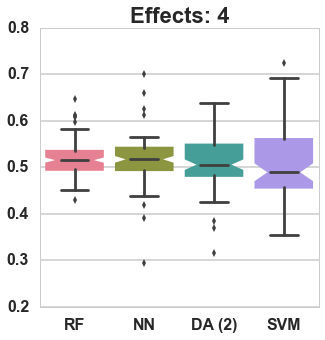

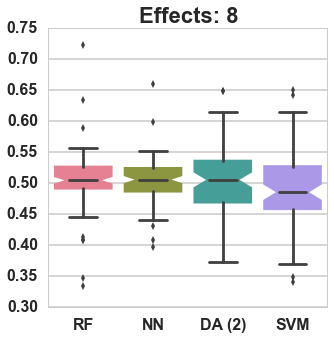

In [33]:
font = {'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
for p in df['effects'].unique():
    print(p)
    df_select = df.loc[(df['effects'] == p)] #& (df['effects'] == 8) & (df['patients'] == 500)
    #                  & (df['mag'] == 1)] & (df['effects'] == 2) & (df['observed'] == 100)]

    four_col = df_select[['Random Forest', 'Nearest Neighbors', da_classifier, comparison_classifier]] #, 'da_2000_2_tree', 'svm']]
    four_col = four_col.rename(columns={'Random Forest':'RF', 'DA (10000)':'DA',
                       'Nearest Neighbors': 'NN', 'svm': 'SVM'})
    
    plt.figure(figsize=(5,5))
    sns.set_style("whitegrid")
    sns.set_context("poster")
    g = sns.boxplot(data=four_col, notch=True, palette="husl")
    g.set_title('Effects: ' + str(p), fontdict=font)
#     g.set_xaxis

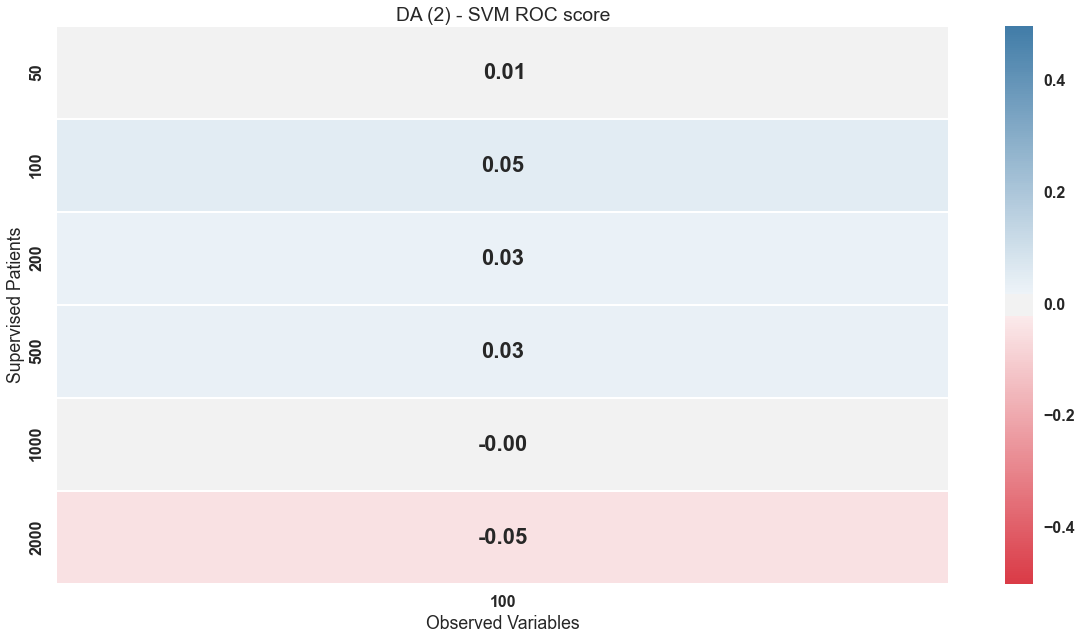

In [34]:
plt.figure(figsize=(20,10))
pt = df.pivot_table(values='diff', index="patients", columns="observed", aggfunc='mean')
ax = sns.heatmap(pt, annot=True, cmap=cmap, vmin=-0.5, vmax=0.5, fmt=".2f", linewidths=.5)
ax.set_title(da_classifier + ' - ' + comparison_classifier + ' ROC score')
ax.set_xlabel('Observed Variables')
ax.set_ylabel('Supervised Patients')

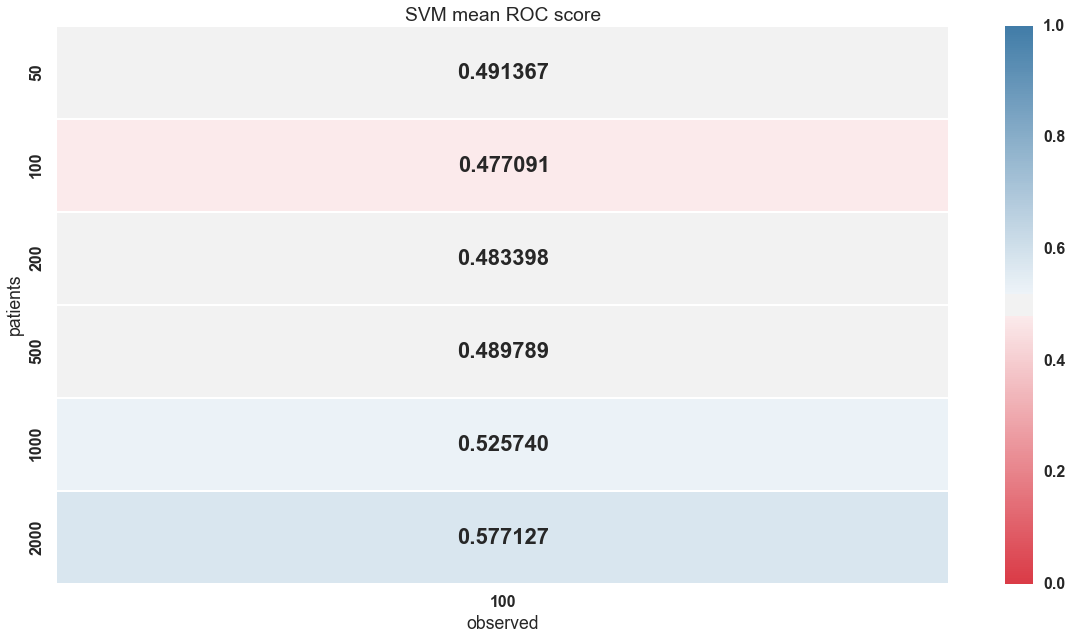

In [35]:
plt.figure(figsize=(20,10))
ax = plt.axes()
pt = df.pivot_table(values=comparison_classifier, index="patients", columns="observed", aggfunc='mean')
sns.heatmap(pt, annot=True, cmap=cmap, fmt="f", vmin=0, vmax=1, linewidths=.5)
ax.set_title(comparison_classifier + ' mean ROC score')

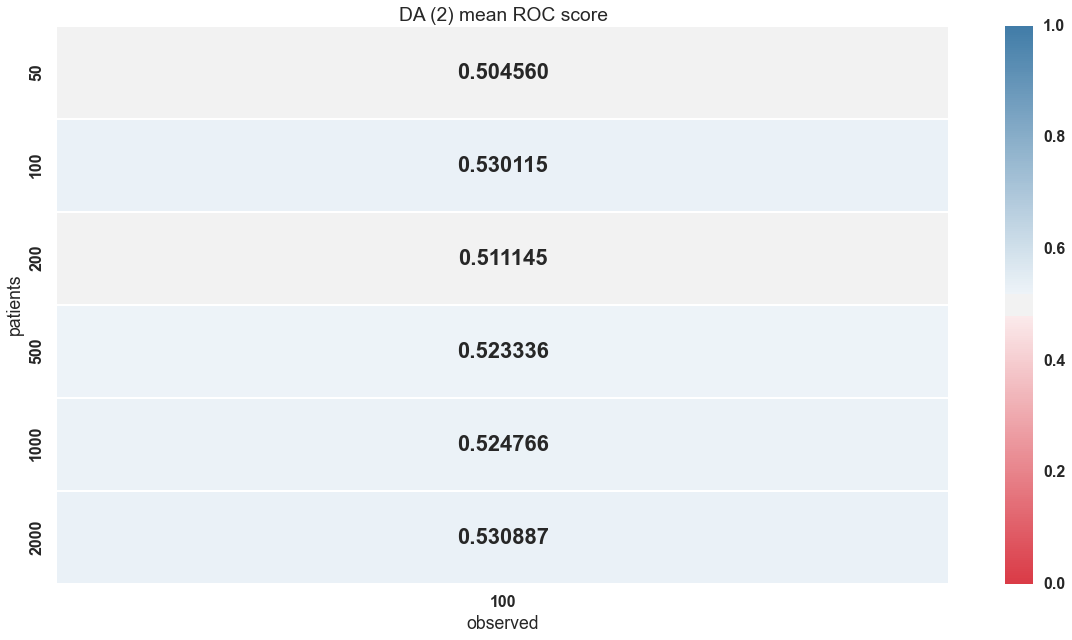

In [36]:
plt.figure(figsize=(20,10))
ax = plt.axes()
pt = df.pivot_table(values=da_classifier, index="patients", columns="observed", aggfunc='mean')
sns.heatmap(pt, annot=True, cmap=cmap, fmt="f", vmin=0, vmax=1, linewidths=.5, ax = ax)
ax.set_title(da_classifier + ' mean ROC score')

### Number of Effects

16
1
2
4
8


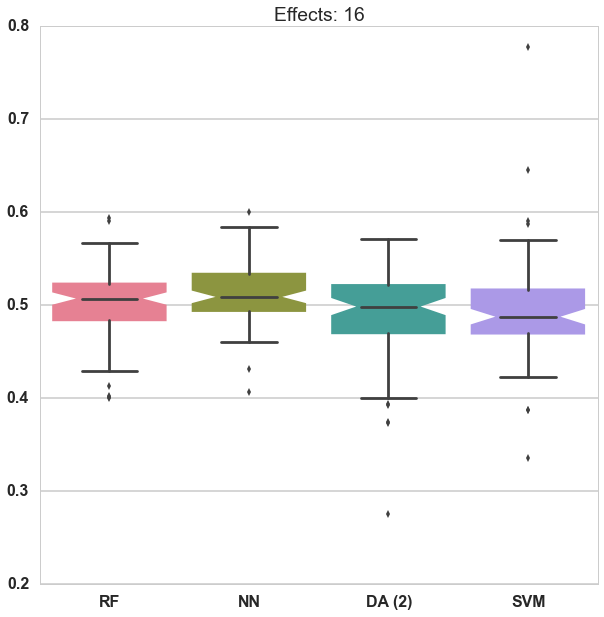

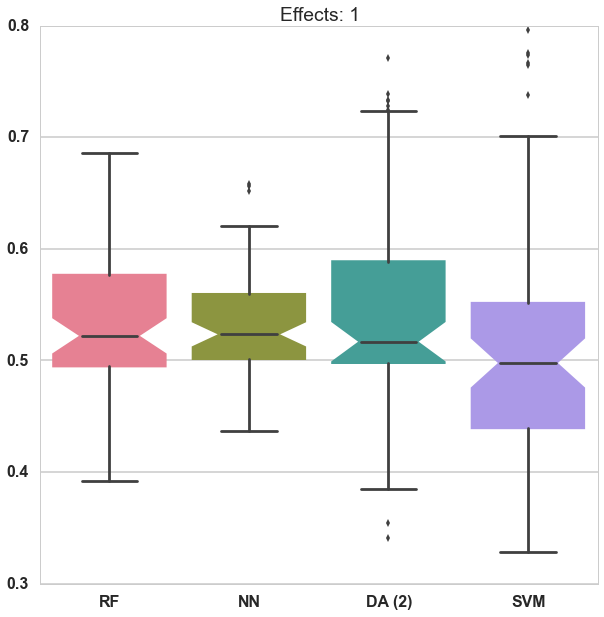

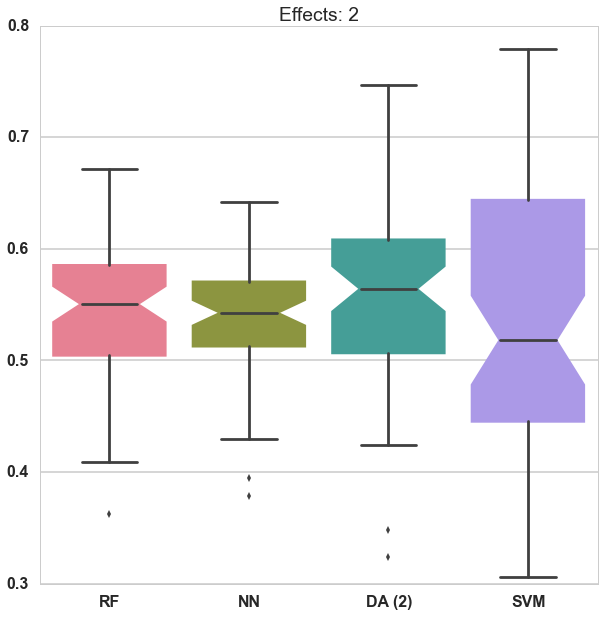

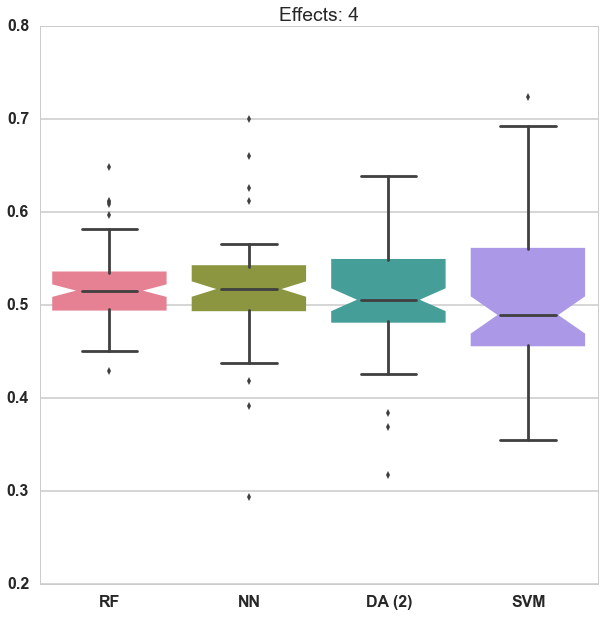

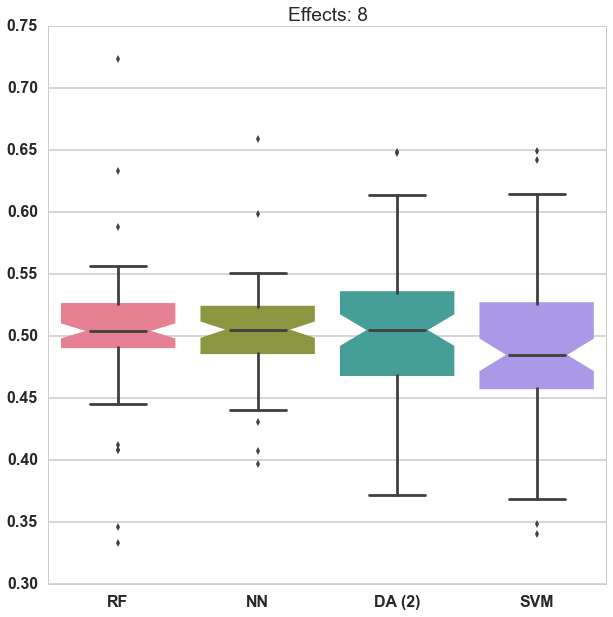

In [37]:
for e in df['effects'].unique():
    print(e)
    df_select = df.loc[(df['effects'] == e)]
#     df_select = df.loc[(df['model'] == 2) & (df['effects'] == e) & (df['patients'] == 500)] # & (df['patients'] == 500)
    #                  & (df['mag'] == 1)] & (df['effects'] == 2) & (df['observed'] == 100)]

    four_col = df_select[['Random Forest', 'Nearest Neighbors', da_classifier, comparison_classifier]] #, 'da_2000_2_tree', 'svm']]
    four_col = four_col.rename(columns={'Random Forest':'RF', 'DA (10000)':'DA',
                       'Nearest Neighbors': 'NN', 'svm': 'SVM'})
    plt.figure(figsize=(10,10))
    sns.set_style("whitegrid")
    sns.set_context("poster")
    g = sns.boxplot(data=four_col, notch=True, palette="husl")
    g.set_title('Effects: ' + str(e))

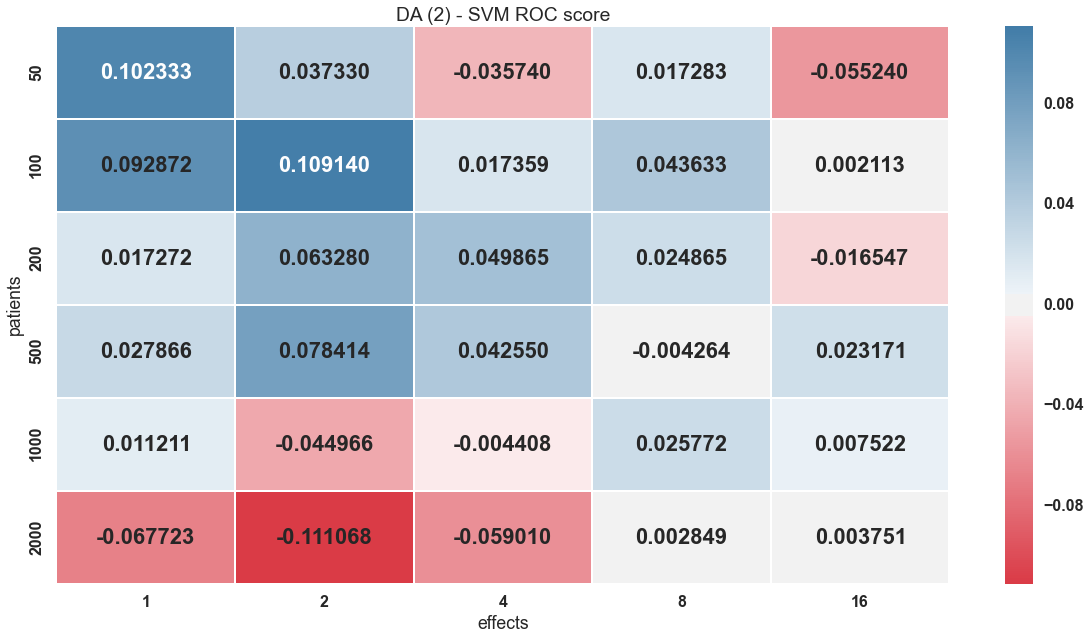

In [38]:
plt.figure(figsize=(20,10))
ax = plt.axes()
pt = df.pivot_table(values='diff', index="patients", columns="effects", aggfunc='mean')
sns.heatmap(pt, annot=True, cmap=cmap, fmt="f", linewidths=.5)
ax.set_title(da_classifier + ' - ' + comparison_classifier + ' ROC score')

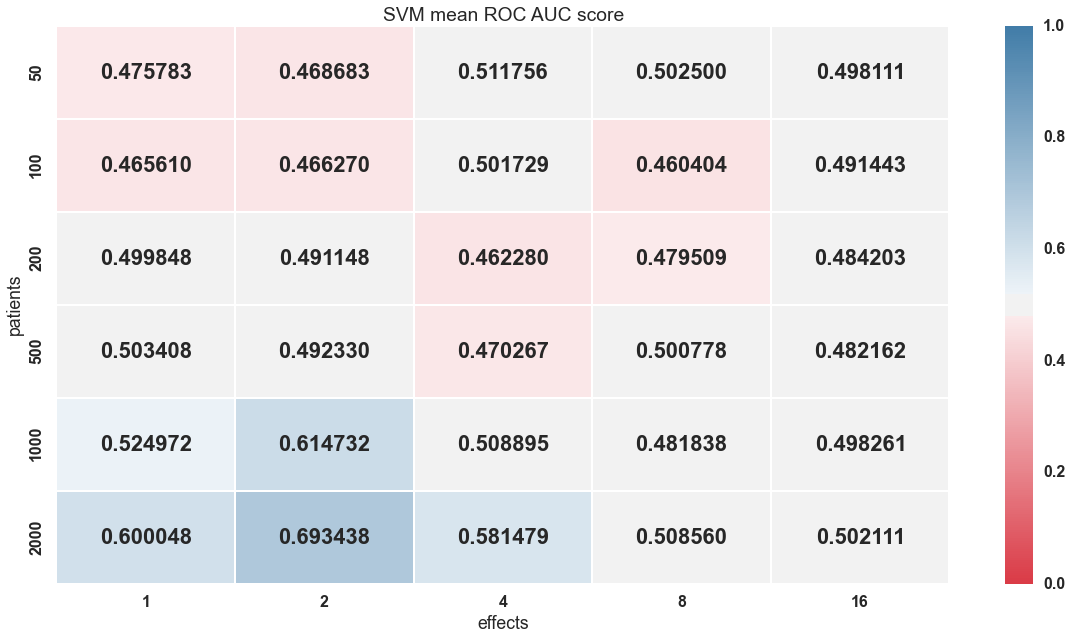

In [39]:
plt.figure(figsize=(20,10))
ax = plt.axes()
pt = df.pivot_table(values=comparison_classifier, index="patients", columns="effects", aggfunc='mean')
sns.heatmap(pt, annot=True, cmap=cmap, vmin=0, vmax=1, fmt="f", linewidths=.5)
ax.set_title(comparison_classifier + ' mean ROC AUC score')

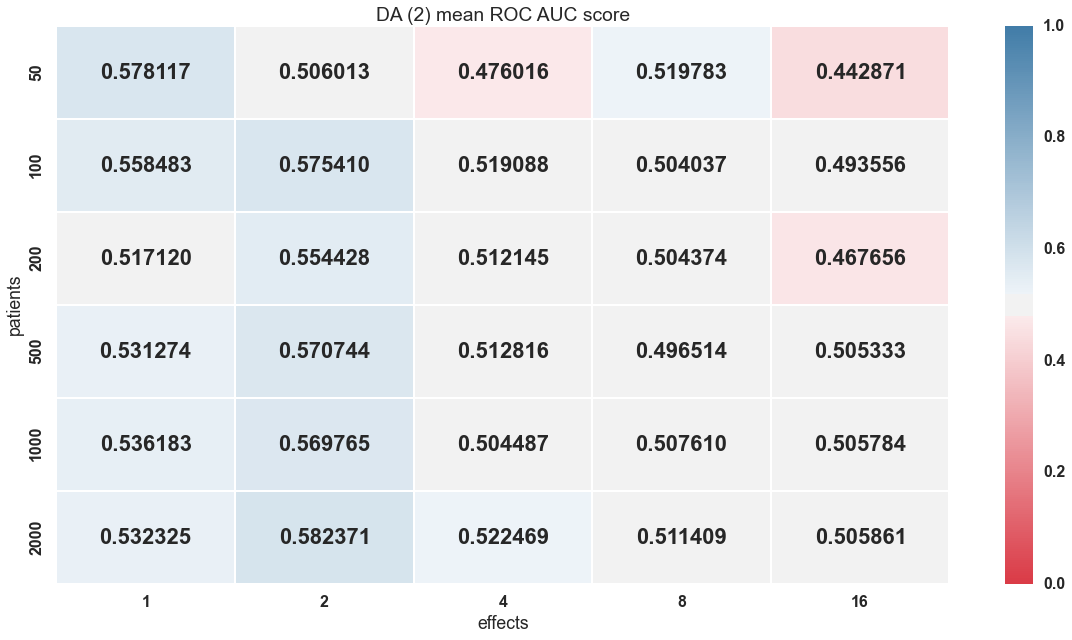

In [40]:
plt.figure(figsize=(20,10))
ax = plt.axes()
pt = df.pivot_table(values=da_classifier, index="patients", columns="effects", aggfunc='mean')
sns.heatmap(pt, annot=True, cmap=cmap, fmt="f", vmin=0, vmax=1, linewidths=.5, ax = ax)
ax.set_title(da_classifier + ' mean ROC AUC score')

### Number of hidden nodes

Index(['DA (2)', 'da_10000_2_nearest_neighbors', 'da_10000_2_rfc',
       'da_10000_2_svm', 'da_10000_2_tree', 'DA (4)',
       'da_10000_4_nearest_neighbors', 'da_10000_4_rfc', 'da_10000_4_svm',
       'da_10000_4_tree', 'DA (8)', 'da_10000_8_nearest_neighbors',
       'da_10000_8_rfc', 'da_10000_8_svm', 'da_10000_8_tree', 'effects',
       'Random Forest', 'mag', 'missing', 'model', 'Nearest Neighbors',
       'observed', 'patients', 'per_effect', 'Limited Random Forest', 'SVM',
       'Decision Tree', 'trial', 'diff'],
      dtype='object')


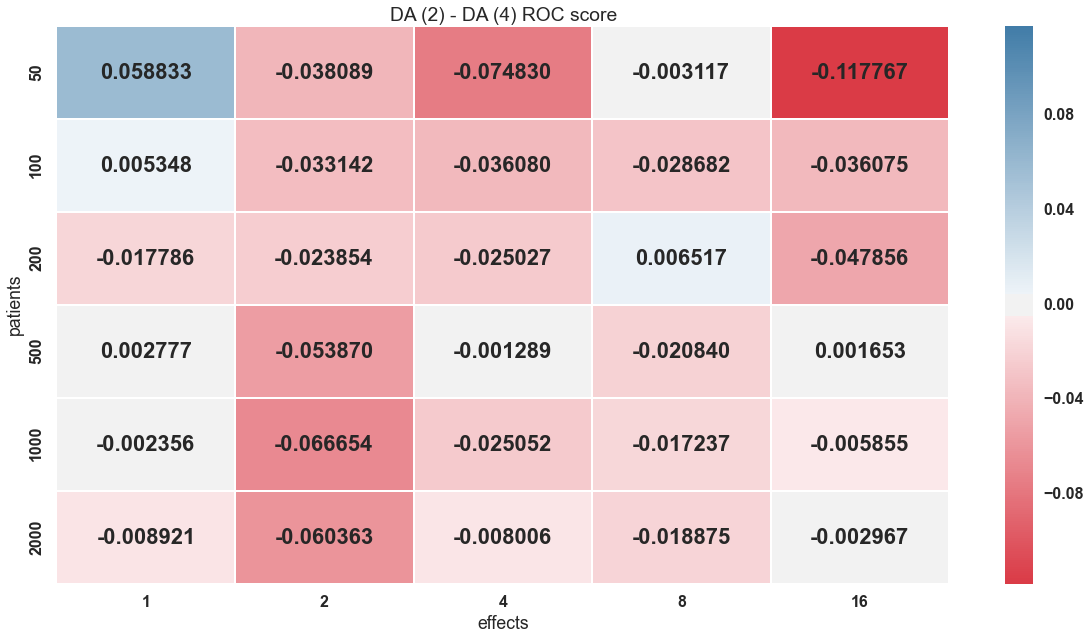

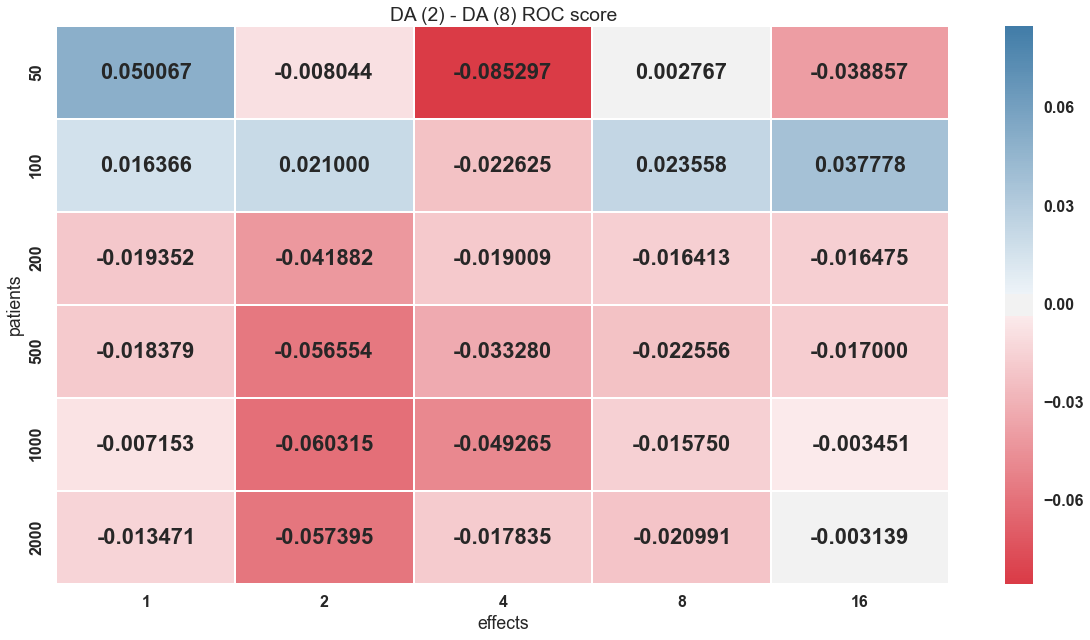

In [41]:
hidden_nodes = [1, 2, 4, 8, 16]
# da_patients = da_classifier.split('_')[1]
# da_nodes = da_classifier.split('_')[2]

print(df.columns)

da_classifier_list = []
for n in hidden_nodes:
    da = 'DA (' + str(n) + ')'
    if (da in df.columns):
        da_classifier_list.append(da)

for da in da_classifier_list:
    if da != da_classifier:
        df['diff'] = df[da_classifier] - df[da]
       
        plt.figure(figsize=(20,10))
        ax = plt.axes()
        pt = df.pivot_table(values='diff', index="patients", columns="effects", aggfunc='mean')
        sns.heatmap(pt, annot=True, fmt="f", cmap=cmap, linewidths=.5)
        ax.set_title(da_classifier + ' - ' + da + ' ROC score')


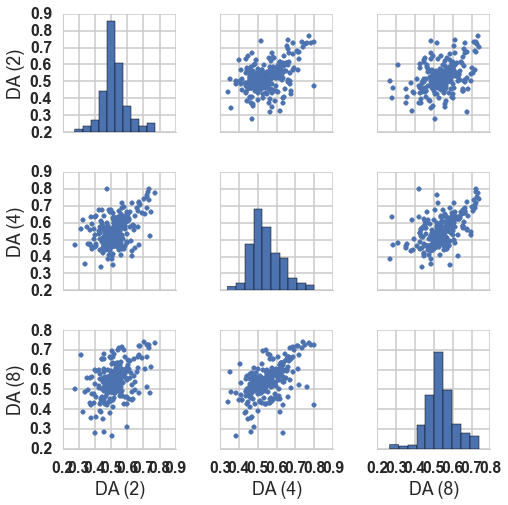

In [42]:
plt.figure(figsize=(10,10))
selected_cols = df[da_classifier_list]
sns.pairplot(selected_cols)

In [43]:
methods = da_classifier_list + [comparison_classifier, 'rfc', 'fullrfc']
print(methods)
for e in df['effects'].unique():
    df_select = df.loc[(df['effects'] == e)]
    
    print(df_select.columns())
    vals = df_select[methods]
    plt.figure(figsize=(20,10))
    sns.set_style("whitegrid")
    sns.set_context("poster")
    g = sns.boxplot(data=vals, notch=True, palette="husl")
    g.set_title('Effects: ' + str(e))

['DA (2)', 'DA (4)', 'DA (8)', 'SVM', 'rfc', 'fullrfc']


TypeError: 'Index' object is not callable

### Effect Magnitude

### Missing Data

In [ ]:
plt.figure(figsize=(20,10))
ax = plt.axes()
pt = df.pivot_table(values='diff', index="effects", columns="missing", aggfunc='mean')
sns.heatmap(pt, annot=True, fmt="f", cmap=cmap, vmin=-0.5, vmax=0.5, linewidths=.5)
ax.set_title(da_classifier + ' - ' + comparison_classifier + ' ROC score')

plt.figure(figsize=(20,10))
ax = plt.axes()
pt = df.pivot_table(values='diff', index="patients", columns="missing", aggfunc='mean')
sns.heatmap(pt, annot=True, fmt="f", cmap=cmap, vmin=-0.5, vmax=0.5, linewidths=.5)
ax.set_title(da_classifier + ' - ' + comparison_classifier + ' ROC score')

In [ ]:
x = 16
s = {}
r = 10000
for i in range(r):
    y = np.random.randint(2, size=x).tolist()
    y_sum = np.sum(y)
    if y_sum in s:
        s[y_sum] += 1
    else:
        s[y_sum] = 1
print(s)

In [ ]:
df = pd.Series(s)
print(df.head())